In [127]:
# Instalar esto (ejecutar la celda):
# Instala el paquete openjdk-8-jdk-headless para Java 8 sin interfaz gráfica de usuario.
!apt-get install openjdk-8-jdk-headless -qq

# Instala la biblioteca PySpark utilizando pip.
!pip install pyspark


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `Install this (run the cell):'


In [4]:
# Importar la biblioteca pandas y asignarle un alias 'pd'.
import pandas as pd

# Importar el módulo pickle para trabajar con serialización de objetos.
import pickle

# Importar la clase SparkSession de PySpark para la creación de una sesión Spark.
from pyspark.sql import SparkSession

# Importar funciones específicas de PySpark para manipulación de DataFrames.
from pyspark.sql.functions import lit, col, sum, count, input_file_name, regexp_extract

# Importar tipos de datos específicos de PySpark para la definición de esquemas.
from pyspark.sql.types import StructType, StructField, StringType, LongType

# Importar las bibliotecas de visualización matplotlib y seaborn.
import matplotlib.pyplot as plt
import seaborn as sns

# Importar el módulo re para trabajar con expresiones regulares.
import re


## review-estados:florida

In [3]:
# Crea una SparkSession
spark = SparkSession.builder.getOrCreate()

# Especifica el directorio principal que contiene directorios de estados
directorio_padre = '/content/drive/MyDrive/reviews-estados/'

# Lee los archivos JSON en Spark DataFrames y extrae el estado de la estructura del directorio
review_estados = spark.read.json(directorio_padre + "*/*.json") \
    .withColumn("state", regexp_extract(input_file_name(), r".*/([^/]+)/[^/]+\.json", 1))


In [4]:
# Obtiene la forma (número de filas y columnas) del DataFrame:
filas, columnas = (review_estados.count(), len(review_estados.columns))
f'Hay {filas} filas y {columnas} columnas.'


'Hay 150000 filas y 9 columnas.'

In [5]:
# Muestra el contenido del DataFrame 'metadata'

review_estados.show()

+--------------------+----------------+----+------+--------------------+--------------------+-------------+--------------------+--------------+
|             gmap_id|            name|pics|rating|                resp|                text|         time|             user_id|         state|
+--------------------+----------------+----+------+--------------------+--------------------+-------------+--------------------+--------------+
|0x8758dd1ca83449d...|     Jenn Thomas|NULL|     5|                NULL|When knowledge is...|1602893531994|11143534694106624...|review-Wyoming|
|0x8758dd1ca83449d...|  Michelle Barta|NULL|     5|{We are lucky to ...|The entire team i...|1575991509006|10361372363526423...|review-Wyoming|
|0x8758dd1ca83449d...|  Bethany Baldes|NULL|     5|                NULL|                NULL|1626981484302|11355668543523675...|review-Wyoming|
|0x8758dd1ca83449d...|    nichole vogt|NULL|     5|                NULL|                NULL|1583381337082|10223535248245823...|review-W

In [6]:
# Para obtener información sobre el DataFrame, incluyendo tipos de datos de las columnas y recuentos de valores nulos:
review_estados.printSchema()


root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- state: string (nullable = false)



In [7]:
# Para contar la cantidad de valores nulos en cada columna:
review_estados.select([sum(col(c).isNull().cast("int")).alias(c) for c in review_estados.columns]).show()


+-------+----+------+------+------+-----+----+-------+-----+
|gmap_id|name|  pics|rating|  resp| text|time|user_id|state|
+-------+----+------+------+------+-----+----+-------+-----+
|      0|   0|146519|     0|134046|66546|   0|      0|    0|
+-------+----+------+------+------+-----+----+-------+-----+



In [8]:
# Para contar la cantidad de filas duplicadas en el DataFrame:
review_estados.groupBy(review_estados.columns).count().filter("count > 1").count()


1191

In [9]:
# Elimina las filas duplicadas
review_estados = review_estados.dropDuplicates()

# Ahora, si cuentas las filas duplicadas, debería dar 0
duplicados = review_estados.groupBy(review_estados.columns).count().filter("count > 1").count()
print(f"El número de filas duplicadas es: {duplicados}")

El número de filas duplicadas es: 0


In [10]:
# Seleccionar las columnas numéricas de interés en el DataFrame 'review_estados'.
columnas_numericas = ['rating']

# Aplicar el método describe() en las columnas numéricas seleccionadas y mostrar el resumen estadístico.
# Este resumen incluye estadísticas como el conteo, la media, la desviación estándar, el mínimo y el máximo.
review_estados.select(columnas_numericas).describe().show()



+-------+-----------------+
|summary|           rating|
+-------+-----------------+
|  count|           148797|
|   mean|4.312714638063939|
| stddev| 1.05190719395729|
|    min|                1|
|    max|                5|
+-------+-----------------+



In [ ]:
review_estados.columns  # Devuelve la lista de nombres de columnas del DataFrame 'metadata'

['gmap_id',
 'name',
 'pics',
 'rating',
 'resp',
 'text',
 'time',
 'user_id',
 'state']

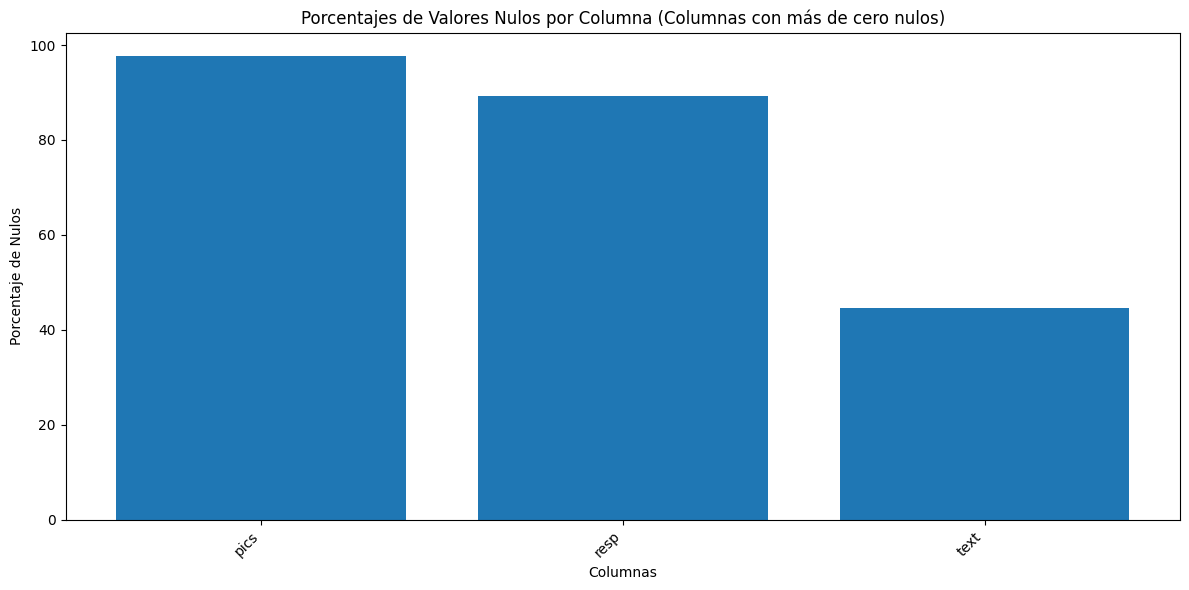

In [11]:
# Almacena el recuento de valores nulos en una lista
recuento_nulos = review_estados.select([sum(col(c).isNull().cast("int")).alias(c) for c in review_estados.columns]).collect()[0]

# Obtiene los nombres de las columnas
nombres_columnas = review_estados.columns

# Calcula el número total de filas
total_filas = review_estados.count()

# Calcula porcentajes de nulos para columnas con más de cero nulos
porcentajes_nulos = [(nombre_columna, recuento_nulo/total_filas * 100) for nombre_columna, recuento_nulo in zip(nombres_columnas, recuento_nulos) if recuento_nulo > 0]

# Desempaqueta los nombres de las columnas y los porcentajes
nombres_columnas, porcentajes = zip(*porcentajes_nulos)

# Crea un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(nombres_columnas, porcentajes)

# Agrega etiquetas y título
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Nulos')
plt.title('Porcentajes de Valores Nulos por Columna (Columnas con más de cero nulos)')

# Rota las etiquetas del eje x para una mejor visibilidad
plt.xticks(rotation=45, ha='right')

# Muestra el gráfico
plt.tight_layout()
plt.show()


In [12]:
# Importar el módulo de funciones de PySpark y asignarle un alias 'F'.
from pyspark.sql import functions as F

# Utilizar la función from_unixtime para convertir la columna 'time' de milisegundos a formato de fecha y hora.
# La división por 1000 se realiza para convertir milisegundos a segundos antes de aplicar from_unixtime.
review_estados = review_estados.withColumn('time', F.from_unixtime(F.col('time') / 1000))


In [13]:
# Utilizar la función withColumn de PySpark para agregar una nueva columna 'weekday' al DataFrame 'review_estados'.
# La nueva columna se genera aplicando la función date_format a la columna 'time', extrayendo el nombre del día de la semana ('EEEE').
review_estados = review_estados.withColumn('weekday', F.date_format('time', 'EEEE'))


In [14]:
# Utilizar la función withColumn de PySpark para modificar la columna 'time' en el DataFrame 'review_estados'.
# La columna 'time' se transforma utilizando la función date_format para cambiar su formato a 'yyyy-MM-dd HH:mm:ss'.
review_estados = review_estados.withColumn('time', F.date_format('time', 'yyyy-MM-dd HH:mm:ss'))


In [15]:
# Muestra el contenido del DataFrame

review_estados.show()

+--------------------+------------------+--------------------+------+--------------------+--------------------+-------------------+--------------------+--------------+---------+
|             gmap_id|              name|                pics|rating|                resp|                text|               time|             user_id|         state|  weekday|
+--------------------+------------------+--------------------+------+--------------------+--------------------+-------------------+--------------------+--------------+---------+
|0x8758f64c1699e5f...|           chris m|                NULL|     3|                NULL|I wish there were...|2019-07-15 16:22:20|11133641532233074...|review-Wyoming|   Monday|
|0x875796a72ca3a52...|   cheryl casebolt|                NULL|     5|                NULL|                NULL|2017-08-03 21:15:39|10958055396488694...|review-Wyoming| Thursday|
|0x876f3b221c8203f...|       Nora Newman|                NULL|     5|                NULL|Love this bar and...

In [16]:
# Utilizar la función withColumn de PySpark para modificar la columna 'time' en el DataFrame 'review_estados'.
# La columna 'time' se transforma utilizando la función to_timestamp para convertir los valores a formato de timestamp.
review_estados = review_estados.withColumn('time', F.to_timestamp('time'))


In [17]:
# Crear una lista 'tipo_dato_time' utilizando una comprensión de lista.
# La lista contiene los tipos de datos correspondientes a la columna 'time' en el DataFrame 'review_estados'.
tipo_dato_time = [tipo for nombre, tipo in review_estados.dtypes if nombre == 'time'][0]

# La variable 'tipo_dato_time' ahora almacena el tipo de dato de la columna 'time' en el DataFrame 'review_estados'.

tipo_dato_time


'timestamp'

In [18]:
# Obtener una lista de tuplas 'tipos_datos' que contiene los nombres y tipos de datos de todas las columnas en el DataFrame 'review_estados'.
tipos_datos = review_estados.dtypes

# La variable 'tipos_datos' ahora almacena la lista de tuplas con los nombres y tipos de datos de las columnas en 'review_estados'.


[('gmap_id', 'string'),
 ('name', 'string'),
 ('pics', 'array<struct<url:array<string>>>'),
 ('rating', 'bigint'),
 ('resp', 'struct<text:string,time:bigint>'),
 ('text', 'string'),
 ('time', 'timestamp'),
 ('user_id', 'string'),
 ('state', 'string'),
 ('weekday', 'string')]

In [19]:
# Utilizar la función select de PySpark para seleccionar todas las columnas anidadas bajo la columna 'resp' en el DataFrame 'review_estados'.
# review_estados1 = review_estados.select("resp.*")

# La variable 'review_estados1' ahora contiene un nuevo DataFrame con todas las columnas anidadas bajo la columna 'resp'.


In [20]:
# Importar la función split de PySpark para dividir una columna en base a un delimitador.
from pyspark.sql.functions import split

# Aplicar la función split a la columna 'gmap_id' en el DataFrame 'review_estados'.
split_col = split(review_estados['gmap_id'], ':')

# Crear dos nuevas columnas 'gmap_id1' y 'gmap_id2' utilizando la función getItem para extraer elementos específicos del resultado de la división.
review_estados = review_estados.withColumn('gmap_id1', split_col.getItem(0))
review_estados = review_estados.withColumn('gmap_id2', split_col.getItem(1))


In [21]:
# Eliminar la columna 'gmap_id' del DataFrame 'review_estados'.
review_estados = review_estados.drop('gmap_id')

# Eliminar la columna 'resp' del DataFrame 'review_estados'.
review_estados = review_estados.drop('resp')

# Eliminar la columna 'pics' del DataFrame 'review_estados'.
review_estados = review_estados.drop('pics')


In [22]:
# Importar funciones específicas de PySpark para trabajar con condiciones y columnas.
from pyspark.sql.functions import when, col, lit

# Utilizar la función withColumn de PySpark para reemplazar los valores nulos en la columna 'text'.
# Cuando el valor en la columna 'text' es nulo, se reemplaza con una cadena vacía (''), de lo contrario, se conserva el valor original.
review_estados = review_estados.withColumn('text', when(col('text').isNull(), lit('')).otherwise(col('text')))


In [23]:
# Muestra el dtaframe

review_estados.show()

+------------------+------+--------------------+-------------------+--------------------+--------------+---------+------------------+------------------+
|              name|rating|                text|               time|             user_id|         state|  weekday|          gmap_id1|          gmap_id2|
+------------------+------+--------------------+-------------------+--------------------+--------------+---------+------------------+------------------+
|           chris m|     3|I wish there were...|2019-07-15 16:22:20|11133641532233074...|review-Wyoming|   Monday|0x8758f64c1699e5f1|0x880dca6012d68bd1|
|   cheryl casebolt|     5|                    |2017-08-03 21:15:39|10958055396488694...|review-Wyoming| Thursday|0x875796a72ca3a52b|0x2d185133710ece7b|
|       Nora Newman|     5|Love this bar and...|2019-05-18 06:52:13|10638674881744781...|review-Wyoming| Saturday|0x876f3b221c8203fd| 0x933d33842c503d2|
|    Dolls Sarkinen|     5|                    |2020-10-06 22:20:24|10950258126560

In [24]:
# Importar funciones específicas de PySpark para calcular los valores mínimos y máximos de una columna de fecha.
from pyspark.sql.functions import min, max

# Utilizar la función select de PySpark para obtener los valores mínimos y máximos de la columna 'time' en el DataFrame 'review_estados'.
min_date, max_date = review_estados.select(min("time"), max("time")).first()

# Imprimir la fecha mínima y máxima obtenidas.
print("Fecha mínima: ", min_date)
print("Fecha máxima: ", max_date)


Fecha mínima:  2009-12-08 22:54:57
Fecha máxima:  2021-09-04 20:59:45


## preliminar Eda metadata-sitios

In [50]:
# Crea la SparkSession
spark = SparkSession.builder.getOrCreate()

# Lista de rutas de archivos JSON
json_files = [
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/1.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/2.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/3.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/4.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/5.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/6.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/7.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/8.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/9.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/10.json',
    '/content/drive/MyDrive/metadata_sitios/metadata-sitios/11.json'
]

# Lee los JSON files y crea el Spark DataFrames
metadata = spark.read.json(json_files)

In [40]:
#"Para obtener la forma (número de filas y columnas) del DataFrame:"
rows, columns = (metadata.count(), len(metadata.columns))
f'There are {rows} rows and {columns} columns.'

'There are 3025011 rows and 15 columns.'

In [41]:
metadata.show()  # Muestra el contenido del DataFrame 'metadata'


+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|          [Pharmacy]|                NULL|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [28]:
metadata.printSchema()  # Imprime el esquema (estructura) del DataFrame 'metadata'


root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Getting here: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)


In [29]:
metadata.columns  # Devuelve la lista de nombres de columnas del DataFrame 'metadata'


['MISC',
 'address',
 'avg_rating',
 'category',
 'description',
 'gmap_id',
 'hours',
 'latitude',
 'longitude',
 'name',
 'num_of_reviews',
 'price',
 'relative_results',
 'state',
 'url']

## Valores atípicos en el número de reseñas

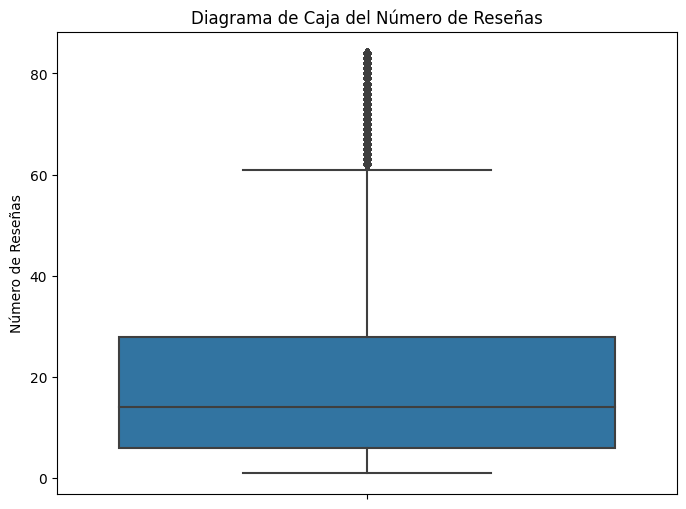

In [30]:
# Selecciona la columna "num_of_reviews"
num_of_reviews_col = "num_of_reviews"  # Reemplazar con el nombre real de la columna para num_of_reviews

# Convierte la columna al tipo de dato numérico
metadata = metadata.withColumn(num_of_reviews_col, col(num_of_reviews_col).cast("double"))

# Calcula los cuartiles y el Rango Intercuartílico (IQR) para la detección de valores atípicos
cuartiles = metadata.approxQuantile(num_of_reviews_col, [0.25, 0.5, 0.75], 0.01)
q1 = cuartiles[0]
q3 = cuartiles[2]
iqr = q3 - q1

# Define los límites inferior y superior para la detección de valores atípicos
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Filtra el DataFrame para mantener las filas dentro de los límites
metadata_filtrado = metadata.filter((col(num_of_reviews_col) >= limite_inferior) & (col(num_of_reviews_col) <= limite_superior))

# Convierte el DataFrame filtrado a Pandas para graficar
pandas_df = metadata_filtrado.select(num_of_reviews_col).toPandas()

# Grafica un diagrama de caja para visualizar la distribución y los valores atípicos
plt.figure(figsize=(8, 6))
sns.boxplot(data=pandas_df, y=num_of_reviews_col)
plt.ylabel("Número de Reseñas")
plt.title("Diagrama de Caja del Número de Reseñas")
plt.show()


## Rango intercuartil: En este caso, la caja se extiende desde aproximadamente 20 hasta 40, lo que indica que la mayoría de las reseñas se encuentran en este rango.

## Bigotes: En este caso, no hay bigotes inferiores visibles, lo que sugiere que no hay valores atípicos bajos o que el mínimo está cerca del primer cuartil. Hay un bigote superior que se extiende hasta alrededor del valor 60.

## Valores atípicos: En este caso, hay un valor atípico cerca del valor 80, lo que indica una reseña que está significativamente por encima del resto.

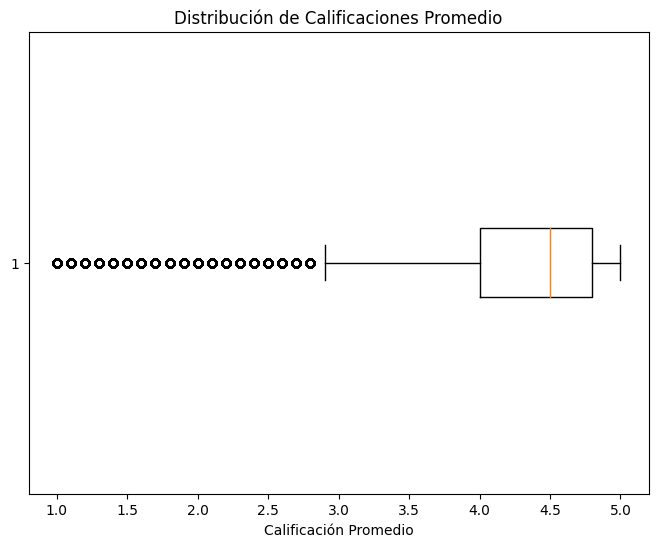

In [ ]:
# Extrae la columna "avg_rating" del DataFrame Spark
avg_ratings_data = metadata.select("avg_rating").rdd.flatMap(lambda x: x).collect()

# Crea el diagrama de caja horizontal
plt.figure(figsize=(8, 6))
plt.boxplot(avg_ratings_data, vert=False)

# Establece etiquetas y título
plt.xlabel("Calificación Promedio")
plt.ylabel("")  # Puedes añadir una descripción aquí si es necesario

plt.title("Distribución de Calificaciones Promedio")

# Muestra el gráfico
plt.show()


## Distribución de calificaciones: Hay puntos negros agrupados en el rango de calificación promedio de aproximadamente 2.0, lo que indica múltiples ocurrencias en esa calificación específica.

## Boxplot: Está presente en el rango de calificación promedio de aproximadamente 4.0. El boxplot muestra la mediana (línea naranja dentro del boxplot) y los cuartiles superior e inferior, proporcionando una visión de la distribución de las calificaciones en este rango.

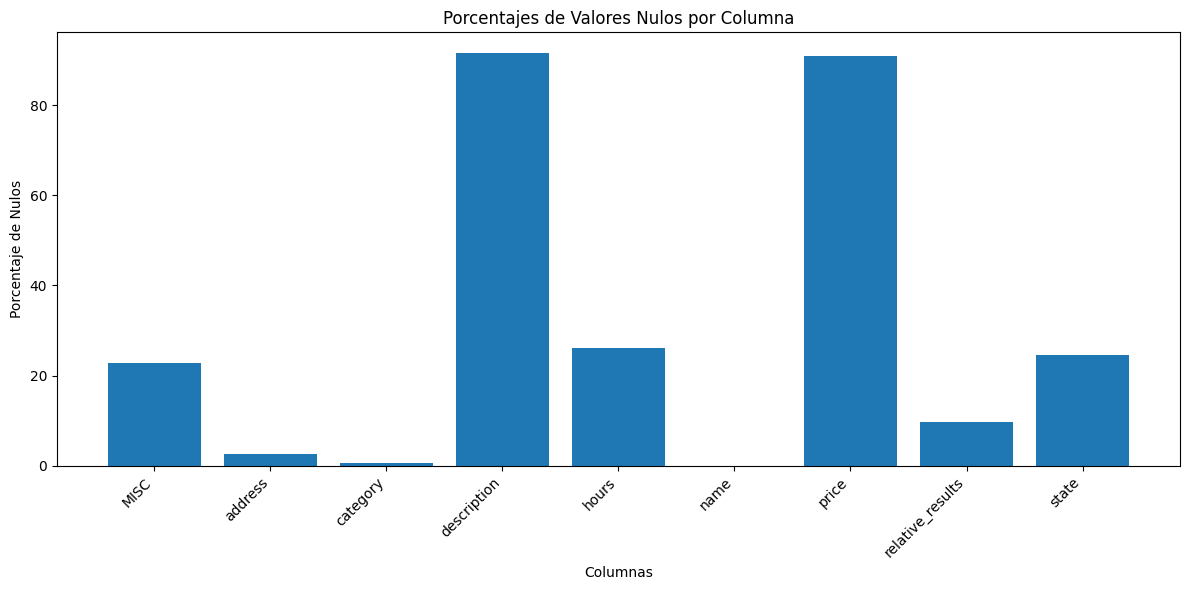

In [ ]:
# Almacena el recuento de valores nulos en una lista
recuento_nulos = metadata.select([sum(col(c).isNull().cast("int")).alias(c) for c in metadata.columns]).collect()[0]

# Obtiene los nombres de las columnas
nombres_columnas = metadata.columns

# Calcula el número total de filas
total_filas = metadata.count()

# Calcula los porcentajes de nulos para columnas con más de cero nulos
porcentajes_nulos = [(nombre_columna, recuento_nulo/total_filas * 100) for nombre_columna, recuento_nulo in zip(nombres_columnas, recuento_nulos) if recuento_nulo > 0]

# Desempaqueta los nombres de las columnas y los porcentajes
nombres_columnas, porcentajes = zip(*porcentajes_nulos)

# Crea un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(nombres_columnas, porcentajes)

# Agrega etiquetas y título
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Nulos')
plt.title('Porcentajes de Valores Nulos por Columna')

# Rota las etiquetas del eje x para una mejor visibilidad
plt.xticks(rotation=45, ha='right')

# Muestra el gráfico
plt.tight_layout()
plt.show()


## Verificando nulos

In [ ]:
# Muestra la cantidad de valores nulos por columna en el DataFrame 'metadata'
metadata.select([sum(col(c).isNull().cast("int")).alias(c) for c in metadata.columns]).show()

+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+
|  MISC|address|avg_rating|category|description|gmap_id| hours|latitude|longitude|name|num_of_reviews|  price|relative_results| state|url|
+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+
|690834|  80511|         0|   17419|    2770722|      0|787405|       0|        0|  37|             0|2749808|          295058|746455|  0|
+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+



In [51]:
# Definir una función llamada 'verificar_inconsistencias_coordenadas' que toma un DataFrame 'df' como parámetro.
def verificar_inconsistencias_coordenadas(df):
    # Definir los nombres de las columnas de latitud y longitud (reemplazar con los nombres reales en el DataFrame).
    columna_latitud = "latitude"
    columna_longitud = "longitude"

    # Filtrar el DataFrame para identificar registros con coordenadas inválidas.
    coordenadas_invalidas = df.filter(
        (col(columna_latitud) < -90) | (col(columna_latitud) > 90) |
        (col(columna_longitud) < -180) | (col(columna_longitud) > 180)
    )

    # Mostrar los registros con coordenadas inválidas.
    coordenadas_invalidas.show()

# Llamar a la función 'verificar_inconsistencias_coordenadas' con el DataFrame 'metadata'.
verificar_inconsistencias_coordenadas(metadata)

+----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+
|MISC|address|avg_rating|category|description|gmap_id|hours|latitude|longitude|name|num_of_reviews|price|relative_results|state|url|
+----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+
+----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+



In [52]:
# Importar la función udf (User Defined Function) y el tipo de dato StringType de PySpark.
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Definir una función Python llamada 'extract_from_list' que toma una lista como parámetro y devuelve una cadena.
def extract_from_list(lst):
    # Verificar si el valor es una lista no vacía.
    if isinstance(lst, list) and len(lst) > 0:
        # Unir los elementos de la lista en una cadena separada por comas.
        return ', '.join(lst)
    # Devolver None si la lista es vacía o si el valor no es una lista.
    return None

# Crear una función UDF (User Defined Function) a partir de la función Python 'extract_from_list'.
extract_from_list_udf = udf(extract_from_list, StringType())


In [53]:
# Utilizar la función withColumn de PySpark para aplicar la función UDF 'extract_from_list_udf' a la columna 'category' en el DataFrame 'metadata'.
metadata = metadata.withColumn('category', extract_from_list_udf(metadata['category']))


In [54]:
# Muestra el dataframe

metadata.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|            Pharmacy|                NULL|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [55]:
# Importar funciones específicas de PySpark para definir funciones UDF y tipos de datos MapType y StringType.
from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType

# Definir una función en Python llamada 'extract_hours' que toma un diccionario 'hours' como parámetro y devuelve un nuevo diccionario.
def extract_hours(hours):
    # Verificar si el diccionario 'hours' no es nulo.
    if hours is not None:
        # Crear un nuevo diccionario incluyendo solo las horas para los días especificados.
        return {hour[0]: hour[1] for hour in hours if hour[0] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}
    # Devolver None si el diccionario 'hours' es nulo.
    return None

# Crear una función UDF (User Defined Function) a partir de la función Python 'extract_hours'.
# Se especifica el tipo de dato de salida como MapType con claves y valores de tipo StringType.
extract_hours_udf = udf(extract_hours, MapType(StringType(), StringType()))

# Aplicar la función UDF 'extract_hours_udf' a la columna 'hours' en el DataFrame 'metadata'.
metadata = metadata.withColumn('hours_extracted', extract_hours_udf(metadata['hours']))

# Seleccionar todas las columnas originales junto con las nuevas columnas para cada día de la semana.
metadata = metadata.select('*', *[metadata['hours_extracted'][day].alias(day) for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])


In [56]:
# Muestra el dataframe

metadata.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|     hours_extracted|       Monday|      Tuesday|    Wednesday|     Thursday|       Friday|     Saturday|     Sunday|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--

In [57]:
# Importar la función split de PySpark para dividir una columna en base a un delimitador.
from pyspark.sql.functions import split

# Aplicar la función split a la columna 'gmap_id' en el DataFrame 'metadata'.
split_col = split(metadata['gmap_id'], ':')

# Crear dos nuevas columnas 'gmap_id1' y 'gmap_id2' utilizando la función getItem para extraer elementos específicos del resultado de la división.
metadata = metadata.withColumn('gmap_id1', split_col.getItem(0))
metadata = metadata.withColumn('gmap_id2', split_col.getItem(1))



In [60]:
# Utilizar la función fillna de PySpark para llenar los valores nulos en columnas específicas del DataFrame 'metadata'.
metadata = metadata.fillna({'name': '', 'address': '', 'category': '', 'Monday': '', 'Tuesday': '', 'Wednesday': '', 'Thursday': '', 'Friday': '', 'Saturday': '', 'Sunday': ''})


In [61]:
metadata.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+------------------+------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|     hours_extracted|       Monday|      Tuesday|    Wednesday|     Thursday|       Friday|     Saturday|     Sunday|          gmap_id1|          gmap_id2|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+-------

In [63]:
# Borra las columnas: 'gmap_id' y 'hours'

metadata = metadata.drop('gmap_id', 'hours')


In [64]:
# Mostrar las columnas de metadata

metadata.columns

['MISC',
 'address',
 'avg_rating',
 'category',
 'description',
 'latitude',
 'longitude',
 'name',
 'num_of_reviews',
 'price',
 'relative_results',
 'state',
 'url',
 'hours_extracted',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'gmap_id1',
 'gmap_id2']

In [65]:
# Importar las funciones col y sum de PySpark para realizar operaciones en columnas y sumar valores.
from pyspark.sql.functions import col, sum

# Utilizar la función select de PySpark junto con una expresión generada dinámicamente para contar y mostrar la cantidad de valores nulos por columna en el DataFrame 'metadata'.
metadata.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in metadata.columns)).show()


+------+-------+----------+--------+-----------+--------+---------+----+--------------+-------+----------------+------+---+---------------+------+-------+---------+--------+------+--------+------+--------+--------+
|  MISC|address|avg_rating|category|description|latitude|longitude|name|num_of_reviews|  price|relative_results| state|url|hours_extracted|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday|gmap_id1|gmap_id2|
+------+-------+----------+--------+-----------+--------+---------+----+--------------+-------+----------------+------+---+---------------+------+-------+---------+--------+------+--------+------+--------+--------+
|690834|      0|         0|       0|    2770722|       0|        0|   0|             0|2749808|          295058|746455|  0|         787405|     0|      0|        0|       0|     0|       0|     0|       0|       0|
+------+-------+----------+--------+-----------+--------+---------+----+--------------+-------+----------------+------+---+---------------+-

In [66]:
# Definir una lista de nombres de columnas a eliminar del DataFrame 'metadata'.
columnas_para_eliminar = ['MISC', 'description', 'price', 'relative_results', 'state', 'hours_extracted']

# Utilizar un bucle for para iterar sobre cada columna en la lista y eliminarla del DataFrame 'metadata'.
for columna in columnas_para_eliminar:
    metadata = metadata.drop(columna)


In [67]:
# Importar las funciones col y sum de PySpark para realizar operaciones en columnas y sumar valores.
from pyspark.sql.functions import col, sum

# Utilizar la función select de PySpark junto con una expresión generada dinámicamente para contar y mostrar la cantidad de valores nulos por columna en el DataFrame 'metadata'.
metadata.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in metadata.columns)).show()


+-------+----------+--------+--------+---------+----+--------------+---+------+-------+---------+--------+------+--------+------+--------+--------+
|address|avg_rating|category|latitude|longitude|name|num_of_reviews|url|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday|gmap_id1|gmap_id2|
+-------+----------+--------+--------+---------+----+--------------+---+------+-------+---------+--------+------+--------+------+--------+--------+
|      0|         0|       0|       0|        0|   0|             0|  0|     0|      0|        0|       0|     0|       0|     0|       0|       0|
+-------+----------+--------+--------+---------+----+--------------+---+------+-------+---------+--------+------+--------+------+--------+--------+



In [147]:
# Utilizar la función filter de PySpark para crear un nuevo DataFrame llamado 'filtro_miami' que contiene solo las filas donde la columna 'address' contiene la cadena 'Miami'.
filtro_miami = metadata.filter(metadata['address'].contains('Miami'))


In [148]:
# Muestra el dataframe

filtro_miami.show()


+--------------------+----------+--------------------+------------------+------------------+--------------------+--------------+--------------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+------------------+------------------+
|             address|avg_rating|            category|          latitude|         longitude|                name|num_of_reviews|                 url|       Monday|       Tuesday|    Wednesday|     Thursday|       Friday|     Saturday|       Sunday|          gmap_id1|          gmap_id2|
+--------------------+----------+--------------------+------------------+------------------+--------------------+--------------+--------------------+-------------+--------------+-------------+-------------+-------------+-------------+-------------+------------------+------------------+
|NTK OUTDOOR, 2315...|       5.0|    Corporate office|        25.7952041|       -80.3660381|         NTK OUTDOOR|            35|https://www

In [145]:
# Obtener el número de filas y columnas del DataFrame 'filtro_miami'.
rows, columns = (filtro_miami.count(), len(filtro_miami.columns))

# Crear una cadena formateada para mostrar la cantidad de filas y columnas en el DataFrame 'filtro_miami'.
f'There are {rows} rows and {columns} columns.'


'There are 20097 rows and 17 columns.'

## business EDA preliminar

In [87]:
# Importar la biblioteca pandas para manipulación de datos.
import pandas as pd

# Leer un archivo en formato pickle (serialización de objetos) y cargarlo en un DataFrame llamado 'business'.
business = pd.read_pickle('/content/drive/MyDrive/business.pkl')

# Mostrar el DataFrame 'business', lo que imprimirá su contenido.
business


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,IN,T6J 5H2,53.468419,-113.492054,3.0,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,DE,37204,36.115118,-86.766925,4.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,AB,46250,39.908707,-86.065088,3.5,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,AB,62025,38.782351,-89.950558,4.0,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Seleccionar todas las filas y columnas del DataFrame 'business', eliminando columnas duplicadas.
# La expresión ~business.columns.duplicated() devuelve una máscara booleana que es True para las columnas que no están duplicadas.
business = business.loc[:, ~business.columns.duplicated()]


In [89]:
# Eliminar las filas del DataFrame 'business' donde la columna 'categories' tiene valores nulos (NaN).
business = business.dropna(subset=['categories'])


In [90]:
# Filtrar el DataFrame 'business' para incluir solo las filas donde la columna 'categories' comienza con la cadena 'restaurant' (ignorando mayúsculas y minúsculas).
# Se utiliza la función str.lower() para convertir las cadenas a minúsculas y str.startswith() para verificar si comienzan con 'restaurant'.
business1 = business[business['categories'].str.lower().str.startswith('restaurant')]

# Mostrar el DataFrame resultante, que contendrá solo las filas correspondientes a restaurantes.
business1


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
23,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,AB,89502,39.476117,-119.789339,2.5,339,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Restaurants, Italian","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
27,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2..."
36,2xVsWBNFwZOxIOdd9Mwnww,Cheeseburger In Paradise,116 N Pottstown Pike,Exton,PA,19341,40.029962,-75.630607,2.5,20,0,"{'NoiseLevel': 'u'average'', 'HasTV': 'True', ...","Restaurants, Burgers",None
41,ljxNT9p0y7YMPx0fcNBGig,Tony's Restaurant & 3rd Street Cafe,312 Piasa St,Alton,IL,62002,38.896563,-90.186203,3.0,94,1,"{'RestaurantsReservations': 'True', 'Restauran...","Restaurants, Specialty Food, Steakhouses, Food...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-21:30',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150306,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,Philadelphia,CA,19128,40.032483,-75.21443,3.0,55,1,"{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...","Restaurants, Specialty Food, Food, Sandwiches,...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
150313,sf_oQ62L8UEnOOLf00nNGA,Pizza Hut,5028 Old Hickory,Hermitage,MO,37076,36.193201,-86.614748,3.0,6,1,"{'RestaurantsTakeOut': 'True', 'GoodForKids': ...","Restaurants, Pizza, Fast Food, Chicken Wings, ...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
150325,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,19 N Bishop Ave,Clifton Heights,TN,19018,39.925656,-75.310344,3.0,11,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Restaurants, Sandwiches, Convenience Stores, C...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
150336,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,MO,19147,39.935982,-75.158665,4.5,35,1,"{'WheelchairAccessible': 'False', 'Restaurants...","Restaurants, Mexican","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [91]:
# Crear una sesión de Spark utilizando la clase SparkSession.
spark = SparkSession.builder.getOrCreate()

# Crear un DataFrame de Spark llamado 'restorant' a partir del DataFrame de pandas 'business1'.
# Esto es necesario para realizar operaciones distribuidas en datos grandes utilizando Spark.
restorant = spark.createDataFrame(business1)


In [92]:
# Muestra el dataframe

restorant.show()

+--------------------+--------------------+--------------------+---------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|           city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+---------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+
|MTSW4McQd7CbVtyjq...|  St Honore Pastries|         935 Race St|   Philadelphia|   CA|      19107|   39.9555052|   -75.1555641|  4.0|          80|      1|{BikeParking -> T...|Restaurants, Food...|{Thursday -> 7:0-...|
|9OG5YkX1g2GReZM0A...|Romano's Macaroni...|  5505 S Virginia St|           Reno|   AB|      89502|   39.4761165|  -119.7893392| 

In [75]:
# Muestra los valores únicos de la columna 'state'
restorant.select('state').distinct().show()


+-----+
|state|
+-----+
|   AZ|
|   LA|
|   NJ|
|   NV|
|   ID|
|   CA|
|   DE|
|   MO|
|   IL|
|   WA|
|   IN|
|   TN|
|   PA|
|   AB|
|   TX|
|   FL|
|   VT|
|   VI|
+-----+



In [93]:
# Filtrar el DataFrame 'restorant' para incluir solo las filas donde la columna 'state' es igual a 'FL' (Florida).
business_florida = restorant.filter(col('state') == 'FL')


In [94]:
# Muestra el dataframe

business_florida.show()

+--------------------+--------------------+--------------------+-------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|         city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+
|ppFCk9aQkM338Rgwp...|                Wawa|    3604 Chestnut St| Philadelphia|   FL|      19104|    39.954573|   -75.1948936|  3.0|          56|      1|{BikeParking -> T...|Restaurants, Auto...|{Thursday -> 0:0-...|
|LGqiubTmpJ-A1L5n7...|      Domino's Pizza|1525 Lapalco Blvd...|       Harvey|   FL|      70058|   29.8753202|    -90.045817|  1.5|     

In [95]:
# Obtener el número de filas y columnas del DataFrame 'business_florida'.
filas, columnas = (business_florida.count(), len(business_florida.columns))

# Crear una cadena formateada para mostrar la cantidad de filas y columnas en el DataFrame 'business_florida'.
f'Hay {filas} filas y {columnas} columnas.'


'Hay 2679 filas y 14 columnas.'

In [96]:
# Importar la función 'col' de PySpark para referenciar columnas.
from pyspark.sql.functions import col

# Convertir las columnas seleccionadas a tipos numéricos en el DataFrame 'business_florida'.
business_florida = business_florida.withColumn('postal_code', col('postal_code').cast('integer'))
business_florida = business_florida.withColumn('review_count', col('review_count').cast('integer'))
business_florida = business_florida.withColumn('latitude', col('latitude').cast('float'))
business_florida = business_florida.withColumn('longitude', col('longitude').cast('float'))
business_florida = business_florida.withColumn('stars', col('stars').cast('float'))


In [98]:
# Importar la función 'udf' y los tipos de datos necesarios de PySpark.
from pyspark.sql.functions import udf
from pyspark.sql.types import MapType, StringType

# Define una función en Python para extraer las horas de la columna 'hours'.
def extract_hours(hours):
    if hours is not None:
        # Crea un diccionario solo con los días especificados ('Monday' a 'Sunday').
        return {day: hours[day] for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] if day in hours}
    return None

# Registra la función como una UDF (User Defined Function).
extract_hours_udf = udf(extract_hours, MapType(StringType(), StringType()))

# Aplica la UDF a la columna 'hours' y crea una nueva columna 'hours_extracted'.
business_florida = business_florida.withColumn('hours_extracted', extract_hours_udf(business_florida['hours']))

# Selecciona todas las columnas originales junto con las nuevas columnas extraídas para cada día de la semana.
business_florida = business_florida.select('*', *[business_florida['hours_extracted'][day].alias(day) for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']])


In [99]:
# Muestra el dataframe

business_florida.show()

+--------------------+--------------------+--------------------+-------------+-----+-----------+---------+----------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+-----------+
|         business_id|                name|             address|         city|state|postal_code| latitude| longitude|stars|review_count|is_open|          attributes|          categories|               hours|     hours_extracted|    Monday|   Tuesday| Wednesday|  Thursday|    Friday|  Saturday|     Sunday|
+--------------------+--------------------+--------------------+-------------+-----+-----------+---------+----------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+-----------+
|ppFCk9aQkM338Rgwp...|                Wawa|    3604 Chestnut St| Philadelphia| 

In [105]:
# Rellenar los valores nulos en las columnas específicas del DataFrame 'business_florida' con valores predeterminados.
business_florida = business_florida.fillna({
    'postal_code': 0,  # Rellenar con el valor 0 en la columna 'postal_code'.
    'categories': '',  # Rellenar con una cadena vacía en la columna 'categories'.
    'Monday': '',      # Rellenar con una cadena vacía en la columna 'Monday'.
    'Tuesday': '',     # Rellenar con una cadena vacía en la columna 'Tuesday'.
    'Wednesday': '',   # Rellenar con una cadena vacía en la columna 'Wednesday'.
    'Thursday': '',    # Rellenar con una cadena vacía en la columna 'Thursday'.
    'Friday': '',      # Rellenar con una cadena vacía en la columna 'Friday'.
    'Saturday': '',    # Rellenar con una cadena vacía en la columna 'Saturday'.
    'Sunday': ''       # Rellenar con una cadena vacía en la columna 'Sunday'.
})


In [106]:
# Importar funciones necesarias de PySpark para realizar el recuento de valores nulos.
from pyspark.sql.functions import col, sum

# Contar el número de valores nulos por columna en el DataFrame 'business_florida'.
business_florida.select(*(sum(col(c).isNull().cast('int')).alias(c) for c in business_florida.columns)).show()


+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+----------+-----+---------------+------+-------+---------+--------+------+--------+------+
|business_id|name|address|city|state|postal_code|latitude|longitude|stars|review_count|is_open|attributes|categories|hours|hours_extracted|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+----------+-----+---------------+------+-------+---------+--------+------+--------+------+
|          0|   0|      0|   0|    0|          0|       0|        0|    0|           0|      0|        24|         0|  488|            488|     0|      0|        0|       0|     0|       0|     0|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+----------+-----+---------------+------+-------+---------+--------+------+--------+------+



In [107]:
# Eliminar las columnas 'hours' y 'hours_extracted' del DataFrame 'business_florida'.
business_florida = business_florida.drop('hours', 'hours_extracted')


In [108]:
business_florida.show()

+--------------------+--------------------+--------------------+-------------+-----+-----------+---------+----------+-----+------------+-------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+-----------+
|         business_id|                name|             address|         city|state|postal_code| latitude| longitude|stars|review_count|is_open|          attributes|          categories|    Monday|   Tuesday| Wednesday|  Thursday|    Friday|  Saturday|     Sunday|
+--------------------+--------------------+--------------------+-------------+-----+-----------+---------+----------+-----+------------+-------+--------------------+--------------------+----------+----------+----------+----------+----------+----------+-----------+
|ppFCk9aQkM338Rgwp...|                Wawa|    3604 Chestnut St| Philadelphia|   FL|      19104|39.954575| -75.19489|  3.0|          56|      1|{BikeParking -> T...|Restaurants, Auto...|   0:0-0:0|   0:0-0

In [109]:
# Seleccionar la columna "categories" del DataFrame "filtro"
filtro_categories = business_florida.select("categories")

# Obtener los valores únicos de la columna "categories"
filtro_categories = filtro_categories.distinct()

# Mostrar todos los valores sin truncar
filtro_categories.show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------+
|Restaurants, Fast Food, Food, Sandwiches, Desserts, Juice Bars & Smoothies                                           |
|Restaurants, Korean, Specialty Food, Imported Food, Food, Ethnic Food                                                |
|Restaurants, Comfort Food, Delis                                                                                     |
|Restaurants, Fast Food, Breakfast & Brunch                                                                           |
|Restaurants, Bagels, Donuts, Food, Breakfast & Brunch                                                                |
|Restaurants, Fast Food, Mexican, Burger

## EDA preliminar "tip"

In [116]:
# Importar la biblioteca json.
import json

# Inicializar una lista vacía para almacenar los datos.
row = []

# Abrir el archivo JSON y leer cada línea.
with open('/content/drive/MyDrive/tip.json', 'r', encoding='utf-8') as f:
    for line in f:
        # Analizar cada línea como un objeto JSON y agregarlo a la lista.
        row.append(json.loads(line))

# Crear un DataFrame de pandas utilizando la lista de objetos JSON.
tip = pd.DataFrame(row)


In [119]:
# Mostrar información sobre el DataFrame 'tip'.
tip.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           908915 non-null  object
 1   business_id       908915 non-null  object
 2   text              908915 non-null  object
 3   date              908915 non-null  object
 4   compliment_count  908915 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 34.7+ MB


In [118]:
# Mostrar las primeras filas del DataFrame 'tip'.
tip.head()


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [120]:
# Calcular la suma de valores nulos por columna en el DataFrame 'tip'.
tip.isnull().sum()


user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64

In [121]:
# Crear una instancia de la SparkSession.
spark = SparkSession.builder.getOrCreate()

# Crear un DataFrame de Spark ('tip_spark') a partir del DataFrame de pandas ('tip').
tip_spark = spark.createDataFrame(tip)


In [122]:
# Realizar una operación de unión entre los DataFrames 'tip_spark' y 'business_florida' basada en la columna 'business_id'.
# Mantener solo las filas que tienen coincidencias en ambas tablas (INNER JOIN).
df_tip = tip_spark.join(business_florida.select('business_id').distinct(), on='business_id', how='inner')


In [144]:
# Muestra el dataframe

df_tip.show()

+--------------------+--------------------+--------------------+-------------------+----------------+
|         business_id|             user_id|                text|               date|compliment_count|
+--------------------+--------------------+--------------------+-------------------+----------------+
|Ixr2-GfYKatXdq1rZ...|QAL5_dSr5Vi2nGBqq...|If you get a bowl...|2015-01-19 18:18:16|               0|
|IiatvDg0R1qwPtKPm...|bJ-xXs5tixOU92RJi...|The ambience is a...|2014-06-13 17:26:14|               0|
|lfIQztu4b_W4b7uCM...|jxac2pQOPQvYY32Zk...|           closed!!!|2016-04-30 21:16:13|               0|
|enywu-fDWecQ1cJl6...|pEGW3WCTMNMoZ2RtV...|Lunch buffet was ...|2015-09-19 16:30:05|               0|
|xsBs3EH4HSy-DOgeb...|QV3lPTxj3CoY7TTRV...|Very good food. W...|2016-08-22 15:59:13|               0|
|peg-QfuNihvtk4P1j...|eWz272mQDO02gtI5K...|Great sandwiches,...|2014-06-10 12:22:23|               1|
|peg-QfuNihvtk4P1j...|K-rMtNcAz0wOWQ81W...|Whoah...too much ...|2016-01-06 18:28:3

## EDA preliminar user

In [5]:
# Leer un archivo en formato Parquet y cargarlo en un DataFrame de pandas llamado 'user'.
user = pd.read_parquet("/content/drive/MyDrive/user.parquet")


In [132]:
# Imprime el dataframe

user

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105592,4QGxxakRZeOlg_qDuxmTeQ,Jennilee,38,2012-01-19 23:33:02,74,9,6,,kmwNG5LZSHFmveg6wYYdrw,0,...,1,0,0,0,1,4,0,0,1,0
2105593,tmelBbVBGAzXBVfH2u_R6g,Gerry,19,2009-06-09 16:34:54,14,5,2,,"BFYdCAMFyjYHDwesndEXEg, _9fTIqfSJc7g3V_o76XRVg...",1,...,1,0,0,0,0,1,0,0,0,0
2105594,tpBznnD6uJN3m_pJubj09w,Emily,26,2013-08-13 23:18:11,4,1,2,,"bKV3ly2MuK-K1cptMrFknQ, liel18zRoSB4tEkUP7i6Cg...",0,...,0,0,0,0,1,0,0,0,0,0
2105595,Kst_srPw7GdYydMFYdCtzw,Heatheranne,25,2015-01-10 00:06:25,21,2,5,,"dzHTk52vbGtbktRm_B-wEg, fOfFLV7IbBDN6lzARaLqdg...",0,...,0,0,0,0,0,1,0,0,0,0


In [133]:
# Mostrar información sobre la estructura y tipos de datos en el DataFrame 'user'.
user.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105597 entries, 0 to 2105596
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 353.4+ MB


In [134]:
# Calcular la suma de valores nulos por columna en el DataFrame 'user'.
user.isnull().sum()


user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

In [135]:
# Muestra las columnas de "user"

user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

<ipython-input-6-fb793047c20e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = user.corr()


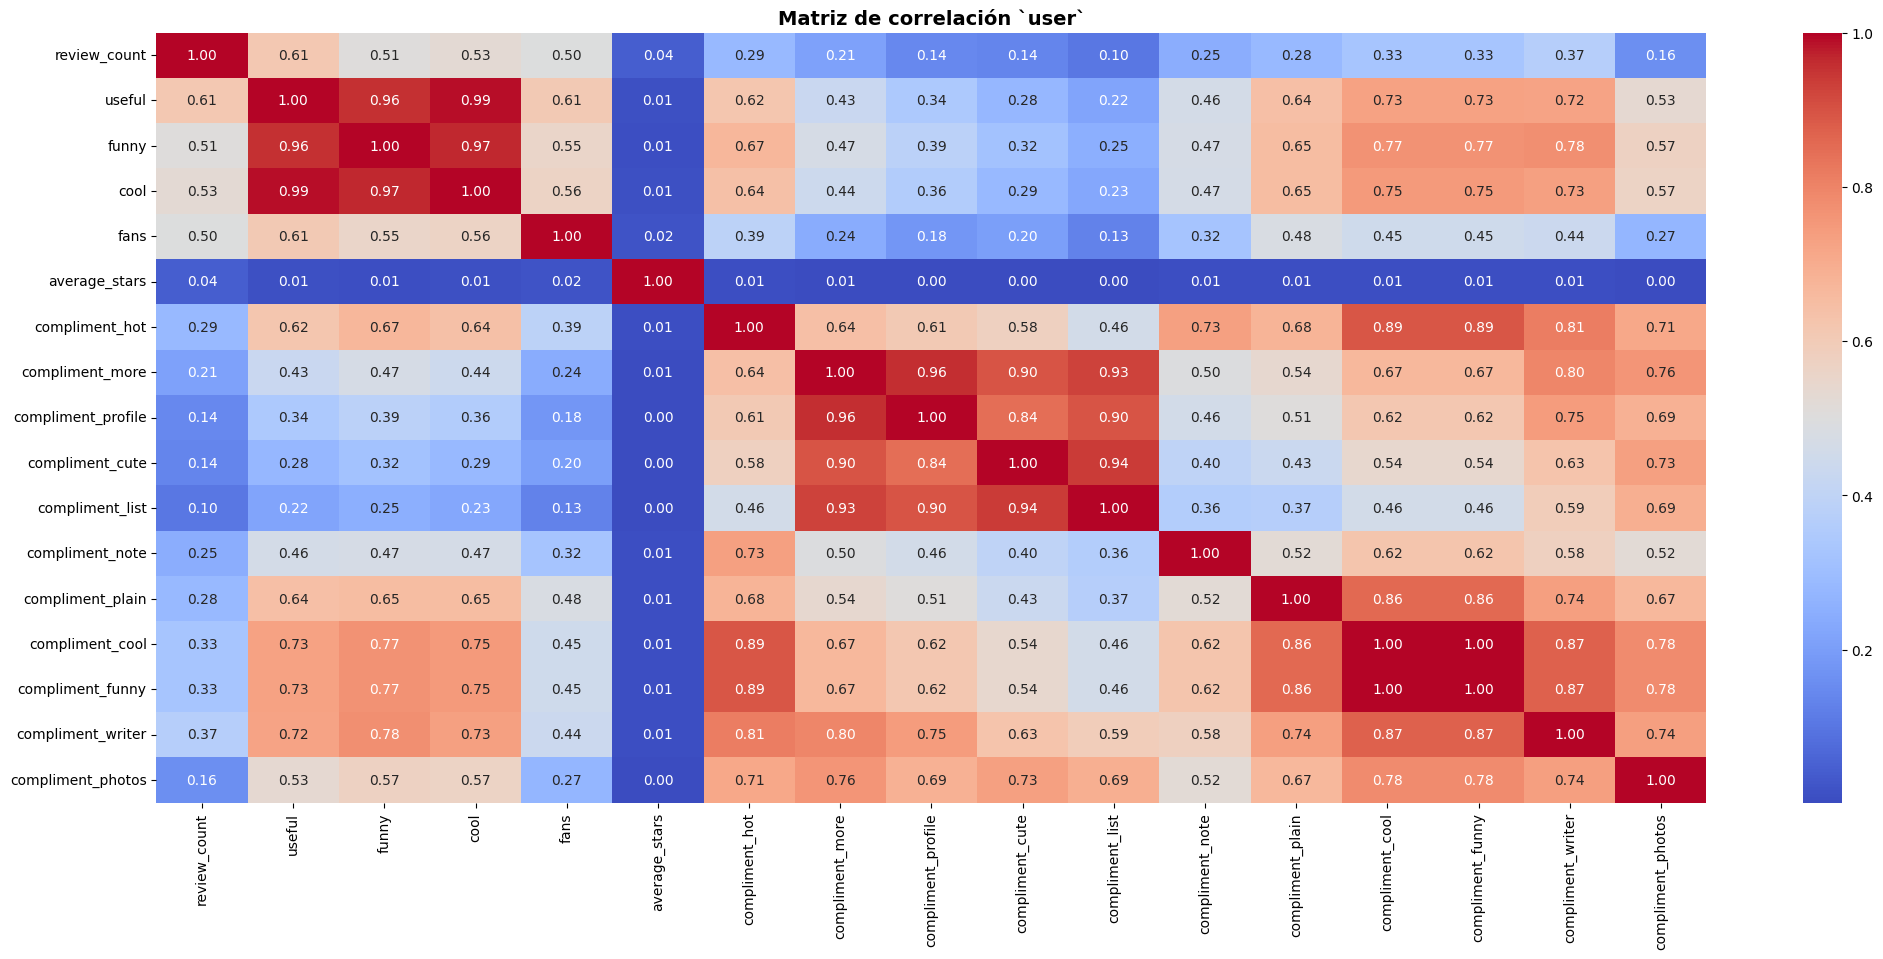

In [6]:
# Calcular la matriz de correlación entre las columnas del DataFrame 'user'.
correlation_matrix = user.corr()

# Crear un heatmap (mapa de calor) utilizando Seaborn para visualizar la matriz de correlación.
plt.figure(figsize=(25, 10))  # Establecer el tamaño de la figura del heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # Anotar los valores y elegir un esquema de color
plt.title('Matriz de correlación `user`', fontsize=14, fontweight='bold')  # Establecer el título del heatmap
plt.show()


- 1.La correlación mide la relación lineal entre dos variables y los valores varían de -1 a 1. Un valor de 1 significa una correlación positiva perfecta, lo que significa que si una variable aumenta, la otra también lo hace. Un valor de -1 significa una correlación negativa perfecta, lo que significa que si una variable aumenta, la otra disminuye. Un valor de 0 significa que no hay correlación.

- 2.Los colores en la matriz también representan la fuerza y la dirección de la correlación. El rojo oscuro representa una correlación positiva fuerte, mientras que el azul oscuro representa una correlación negativa fuerte.

**Por ejemplo, se observa la celda que intersecta ‘review_count’ y ‘useful’, se puedes ver la correlación entre estas dos variables. El valor es cercano a 1 y el color es rojo, significa que hay una fuerte correlación positiva entre la cantidad de revisiones y la utilidad de las mismas.**

In [136]:
# Seleccionar un subconjunto específico de columnas en el DataFrame 'user'.
user = user.loc[:, ['user_id', 'name', 'review_count', 'yelping_since', "friends", "elite", "fans"]]


In [137]:
# Imprime el dataframe "user"

user

,user_id,name,review_count,yelping_since,friends,elite,fans
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",2007,267
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...","2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...","2009,2010,2011,2012,2013",52
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...","2009,2010,2011",28
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",,1
...,...,...,...,...,...,...,...
2105592,4QGxxakRZeOlg_qDuxmTeQ,Jennilee,38,2012-01-19 23:33:02,kmwNG5LZSHFmveg6wYYdrw,,0
2105593,tmelBbVBGAzXBVfH2u_R6g,Gerry,19,2009-06-09 16:34:54,"BFYdCAMFyjYHDwesndEXEg, _9fTIqfSJc7g3V_o76XRVg...",,1
2105594,tpBznnD6uJN3m_pJubj09w,Emily,26,2013-08-13 23:18:11,"bKV3ly2MuK-K1cptMrFknQ, liel18zRoSB4tEkUP7i6Cg...",,0
2105595,Kst_srPw7GdYydMFYdCtzw,Heatheranne,25,2015-01-10 00:06:25,"dzHTk52vbGtbktRm_B-wEg, fOfFLV7IbBDN6lzARaLqdg...",,0


In [141]:
# Convertir la columna 'yelping_since' a formato de fecha y hora en el DataFrame 'user'.
user['yelping_since'] = pd.to_datetime(user['yelping_since'])


## Se imprimen los nombres de las columnas para empezar a conformar el modelo relacional.

In [110]:
metadata.columns

['address',
 'avg_rating',
 'category',
 'latitude',
 'longitude',
 'name',
 'num_of_reviews',
 'url',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'gmap_id1',
 'gmap_id2']

In [111]:
review_estados.columns

['name',
 'rating',
 'text',
 'time',
 'user_id',
 'state',
 'weekday',
 'gmap_id1',
 'gmap_id2']

In [124]:
business_florida.columns

['business_id',
 'name',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'attributes',
 'categories',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday']

In [149]:
filtro_miami.columns

['address',
 'avg_rating',
 'category',
 'latitude',
 'longitude',
 'name',
 'num_of_reviews',
 'url',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'gmap_id1',
 'gmap_id2']

In [142]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'elite',
       'fans'],
      dtype='object')

In [143]:
df_tip.columns

['business_id', 'user_id', 'text', 'date', 'compliment_count']